# <center><font color=red>A Tale of 10 Million Bike Rides</font></center>
![bike_img](https://tfl.gov.uk/cdn/static/cms/images/santander-land.jpg)

### 1.0 Project Background

This analysis is part of the course ST445 (Managing and Visualising Data) at the London School of Economics. This project was inspired by Todd Schneider's analysis of bike sharing data in New York. Bike sharing has taken off in a number of cities around the world and contributes greatly to reducing environment impact and improving liveability in cities. Understanding how users engage with the system can help to improve the system's efficiency and user-friendliness.

The aim of the project is to conduct an exploratory data analysis on the London bike sharing open dataset. The goals of the analysis include:
-  Visualising bike ride numbers and durations and how they change with:
   *  time of day
   *  day of week
   *  day of year
-  Understanding the effects of weather on hiring a bicyle in terms of:
   *  temperature
   *  precipitation
-  Exploring bike stations by looking at:
   *  popularity to start a ride
   *  popularity to end a ride
   *  balance (difference between start and end)
   *  interactions of no. rides vs distance
   *  network interactions

The bike hires dataset is from [Transport for London](https://tfl.gov.uk/info-for/open-data-users/our-open-data) and the weather data has been aggregated for London from [Met office Data](http://catalogue.ceda.ac.uk/uuid/319b3f878c7d4cbfbdb356e19d8061d6)

### Let's get started?
We will start by importing the main packages we need for data wrangling and visualisation:

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
%matplotlib inline

import numpy as np
import pandas as pd
import glob
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xml.etree.ElementTree as ET
import geopy.distance

### 2.0 The Bike Data

The bike hire data is available by month as separate csv files. Although 2017 data is available, we will focus on **2016 data** as the December data for 2017 is still not available and granular open weather data is not available for 2017 dates. 

We start with data preparation by importing all the csv files into a pandas dataframe and parse the date column of interest. The data has a unique rental ID for every ride, the duration of the ride in seconds, the bike ID, start and end timestamps, start and end station IDs along with their names. We also add in a column for the hour of the day and the day of the week which we will use later.

In [3]:
path ='2016TripData'
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
col_names = ['rental_id','duration','bike_id','end_date','end_station_id','end_station_name','start_date',
             'start_station_id','start_station_name']
df_list = []
#use only first 9 columns as some files have additional columns
cols=list(range(9))
for file_ in allFiles:
    df = pd.read_csv(file_,names=col_names,usecols=cols,header=0,
                     parse_dates=['start_date'],dayfirst=True,infer_datetime_format=True)
    df_list.append(df)
frame=pd.concat(df_list,ignore_index=True)
#drop missing values: negligible number of hire data has no duration/timestamps
frame = frame.dropna(axis=0, how='any')
frame = frame.reset_index(drop=True)
frame['day_of_week'] = frame['start_date'].dt.dayofweek
frame['hour'] = frame['start_date'].dt.hour
frame.head()

,rental_id,duration,bike_id,end_date,end_station_id,end_station_name,start_date,start_station_id,start_station_name,day_of_week,hour
0,56149114,540.0,870.0,20/07/2016 00:09,163.0,"Sloane Avenue, Knightsbridge",2016-07-20,222,"Knightsbridge, Hyde Park",2,0
1,56149118,480.0,8772.0,20/07/2016 00:08,28.0,"Bolsover Street, Fitzrovia",2016-07-20,271,"London Zoo, The Regent's Park",2,0
2,56149133,1320.0,5247.0,20/07/2016 00:22,22.0,"Northington Street , Holborn",2016-07-20,348,"Grosvenor Square, Mayfair",2,0
3,56149134,600.0,3926.0,20/07/2016 00:10,61.0,"Great Dover Street, The Borough",2016-07-20,154,"Waterloo Station 3, Waterloo",2,0
4,56149117,480.0,2038.0,20/07/2016 00:08,721.0,"Wendon Street, Old Ford",2016-07-20,492,"The Green Bridge, Mile End",2,0


### 3.0 The Basics

Let's look at some quick numbers. In 2016, there were over **10 million rides** powered by around **13,000 bikes** with an average duration of **21 mins**, covering around **800 bike stations**. With a population of around 9 million, there have been more bike rides in 2016 than Londoners, without including private bike rides.

In [4]:
print ("Total rides in 2016: {:,}".format(frame.shape[0]))
print("Average ride duration in 2016: "+str(round(frame['duration'].mean()/60))+" minutes")
df_stations = pd.concat([frame['end_station_name'],frame['start_station_name']])
print("No. of unique bike stations: "+str(df_stations.nunique()))
print("No. of unique bikes in operation: {:,}".format((frame['bike_id'].nunique())))

Total rides in 2016: 10,348,138
Average ride duration in 2016: 21 minutes
No. of unique bike stations: 807
No. of unique bikes in operation: 12,958


### 3.1 The Flow of Time

Diving right into the data, let's understand how bike rides interact with time. We start by taking the start date timestamps as a time series and grouping up the number of rides at a day level. The bike hiring over time seems quite volatile, almost like a stock market. 

As we see, biking follows patterns of seasons with people riding more from spring and choosing warmer forms of transport during the colder months. Let's try and break down the volatility further...

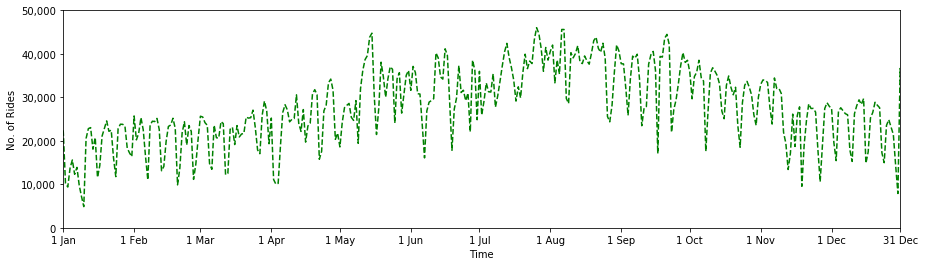

In [5]:
#convert start dates into a series and group it up at a daily level and visualise the flow over the year
rides_by_day = frame['start_date']
rides_by_day.index=frame['start_date']
rides_by_day = rides_by_day.resample('D').size().reset_index(name='rides')
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(rides_by_day['rides'],'g--')
ax.set_xlim([0,366]),ax.set_xlabel('Time'), ax.set_ylabel('No. of Rides'), ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ','))), ax.set_ylim([0,50000]),plt.xticks([0,31,60,91,121,152,182,213,244,274,305,336,366], ['1 Jan', '1 Feb', '1 Mar','1 Apr', '1 May', '1 Jun','1 Jul', '1 Aug', '1 Sep','1 Oct','1 Nov','1 Dec','31 Dec']);

### 3.2 A Weekly Snapshot

Clearly, a large part of the above volatility comes from biking patterns across the week. As we see below, riders ride most from Tuesday-Thursday with about 15% of total rides on each of these days. Rides dip low over the weekend which sustains slightly through the Monday blues.

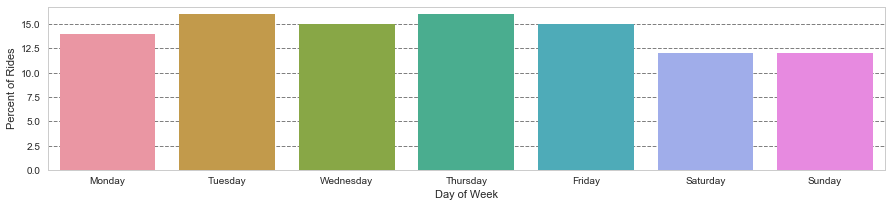

In [7]:
#group up rides at a day of week level and look at the percent contribution for each day of week
rides_per_day= frame[['start_date','day_of_week']].groupby(['day_of_week']).size().reset_index(name='rides')
rides_per_day['Percent of Rides']=round(rides_per_day['rides']/frame.shape[0]*100)
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
rides_per_day['Day of Week'] = rides_per_day['day_of_week'].map(dayOfWeek)
sns.set(style='ticks',color_codes=True)
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,3))
ax = sns.barplot(x="Day of Week",y="Percent of Rides",data=rides_per_day)
plt.grid(color='grey', which='major', axis='y', linestyle='--')
ax.yaxis.grid(True);

### 3.3 A Daily Snapshot of No. of Rides

As we see from the daily snapshot below, ride volume changes based on the time of the day as well as the day of the week. The weekdays are dominated by the pattern expected for regular commutes to and from work and the weekends have the distribution of leisure riders enjoying their afternoons out in the city. 

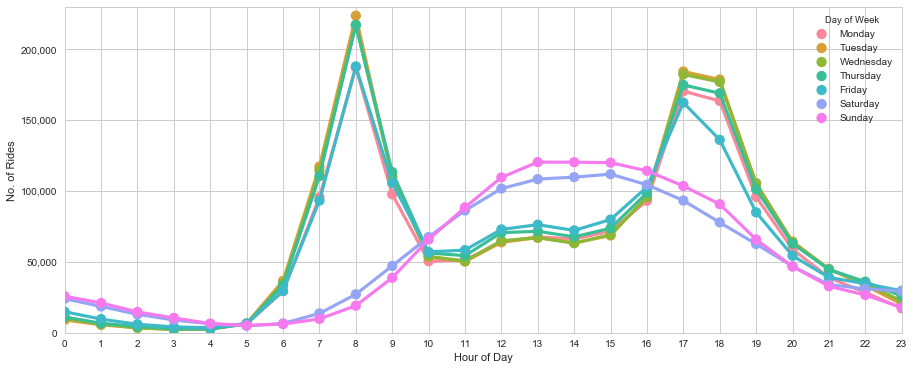

In [8]:
#group up rides at an hourly and day of week level
rides_per_hour_week= frame[['start_date','hour','day_of_week']].groupby(['hour','day_of_week']).size().reset_index(name='rides')
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
rides_per_hour_week['Day of Week'] = rides_per_hour_week['day_of_week'].map(dayOfWeek)
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.pointplot(x="hour", y="rides", hue="Day of Week",data=rides_per_hour_week)
ax.set_ylim([0,230000]),ax.set_xlim([0,23]),ax.set_xlabel('Hour of Day'), ax.set_ylabel('No. of Rides'), ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(True); 

### 3.4 A Daily Snapshot of Ride Duration

Let's look at ride duration instead. As we see from the daily snapshot below, ride duration changes based on the time of the day as well as the day of the week. Weekend rides are longer than weekday rides. We also see that strangely ride durations are longer in the wee hours of the day. This anomaly might be because there are very few rides happening in these hours as we saw in the previous graph and thus the outliers stand out more. Lastly, we also see that duration of rides gets longer in the middle of the day, perhaps these could be more casual riders compared to last mile commuters. 

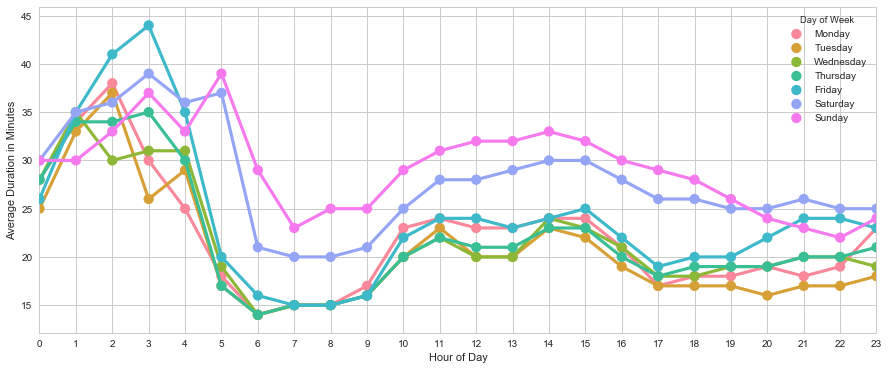

In [9]:
#group up data at an hour and day of week level and take the mean duration for each group
duration_week= frame[['duration','hour','day_of_week']].groupby(['hour','day_of_week'])['duration'].mean().reset_index(name='avg_duration')
duration_week['avg_duration'] = round(duration_week['avg_duration']/60)
duration_week['Day of Week'] = duration_week['day_of_week'].map(dayOfWeek)
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.pointplot(x="hour", y="avg_duration", hue="Day of Week",data=duration_week)
ax.set_xlim([0,23]),ax.set_xlabel('Hour of Day'), ax.set_ylabel('Average Duration in Minutes')
ax.grid(True); 

### 4.0 Weather Interactions

Next, we will switch gears to try and understand the variation in number of rides that could not be explained by time. A key factor that affects moods (and conversations) in the UK is the weather. It will not doubt have an effect on the number of people coming out to ride bikes as well. 

To understand this interaction, we take a look at weather data from the Met Office. Only mean temperature (degrees) and precipitation (in mm) is available, and that too at a daily level, so we will work with this data. The data was downloaded as a csv for the city of London area.

We take our ride data and group it up at a daily level and then merge it with the weather data. Finally, add a flag to indicate if a day is a weekday or not.

In [10]:
#take no. of rides at a daily level and merge with weather data by the date
weather = pd.read_csv('Weather Data/london_weather.csv',parse_dates=['date'],
                     dayfirst=True,infer_datetime_format=True)
frame['start_date_date']=frame['start_date'].dt.date
frame['start_date_date']=pd.to_datetime(frame['start_date_date'])
rides_per_day = pd.DataFrame(frame.groupby('start_date_date').size().reset_index(name='rides'))
hires_with_weather = pd.merge(rides_per_day, weather, how='inner', left_on=['start_date_date'], right_on=['date'])
hires_with_weather = hires_with_weather[['date','rides','mean_temp','precipitation']]
hires_with_weather['Weekday']=hires_with_weather['date'].dt.dayofweek<5
hires_with_weather.head()

,date,rides,mean_temp,precipitation,Weekday
0,2016-01-01,9797,6.15,2.82,True
1,2016-01-02,7195,7.18,4.41,False
2,2016-01-03,4869,7.48,7.45,False
3,2016-01-04,20532,8.32,0.92,True
4,2016-01-05,22804,8.48,1.45,True


### 4.1 Influence of Temperature

As we see below, temperature has a big influence of one's decision to ride a bike. Interestingly, this decision is influenced differently for weekday and weekend riders. Weekday riders seem to less influenced by the same rise in temperature (lower slope).

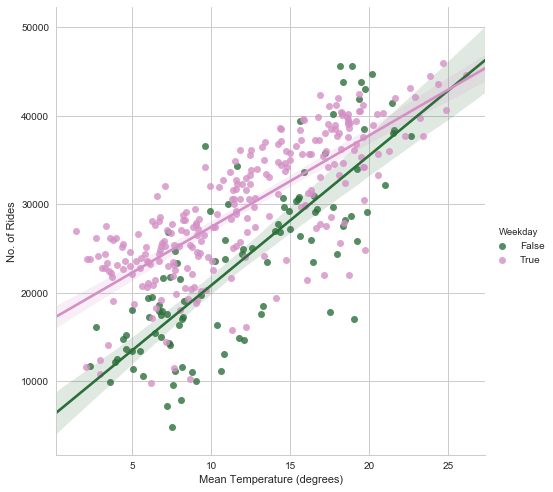

In [13]:
#scatter plot with best fit lines
sns.lmplot(x="mean_temp", y="rides", data=hires_with_weather,hue="Weekday",size=7,palette='cubehelix')
plt.xlabel('Mean Temperature (degrees)'), plt.ylabel('No. of Rides');

### 4.2 Influence of Precipitation

As we see below, precipitation also has an influence of one's decision to ride a bike. Again, weekday riders seem to less influenced by the same rise in rain. Unsurprisingly, Londoners come out to ride their bikes when it's sunny and warm. We don't have data on wind and humidity, which would have been somewhat better at breaking the interactions further.

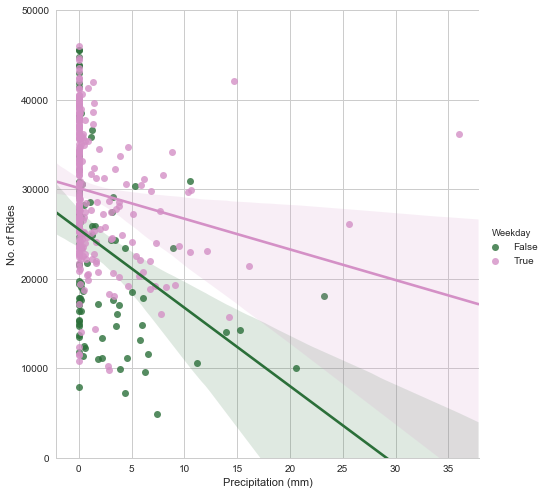

In [14]:
#scatter plot with best fit lines
sns.lmplot(x="precipitation", y="rides", data=hires_with_weather,hue="Weekday",size=7, palette='cubehelix')
plt.xlabel('Precipitation (mm)'), plt.ylabel('No. of Rides'), plt.ylim([0,50000]);

### 4.3 Modelling the Weather Interactions

Finally, we run a simple OLS using No. of rides as a dependent variable and temperature, precipitation and weekday as explanatory variables. 

**TL;DR** every **1 degree** rise in temperature is associated with around **1000 more rides**, every **one mm** rise in precipitation is associated with around **500 fewer rides** and **weekdays** pull in around **5000 rides** more than weekends. It's interesting to quantify these interactions because it can help the bike system planner to better adjust the system based on these changes e.g. adding more bikes on warm, sunny weekdays.

In [15]:
import statsmodels.formula.api as smf
model = smf.ols(formula='rides ~ mean_temp + precipitation + Weekday', data=hires_with_weather).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     255.5
Date:                Sun, 14 Jan 2018   Prob (F-statistic):           5.38e-89
Time:                        20:01:32   Log-Likelihood:                -3631.2
No. Observations:                 366   AIC:                             7270.
Df Residuals:                     362   BIC:                             7286.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.104e+04    752.536     14.667      0.000    9557.337    1.25e+04
Weekday[T.True]  5522.2099    573.469      9.629      0.000    4394.460    6649.959
mean_temp        1140.9970     46.499     24.538      0.000    1049.556    1232.438
precipitation    -461.2482     66.681     -6.917      0.000    -592.380    -330.117
==============================================================================
Omnibus:                       11.569   Durbin-Watson:                   1.510
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               21.408
Skew:                          -0.120   Prob(JB):                     2.25e-05
Kurtosis:                       4.160   Cond. No.                         43.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 5.0 Station Dynamics - Popularity

Next, let's switch gears and look at station dynamics. There are over 800 bike stations but not all stations are created equally. 

We start by grouping the number of rides that start and end at each station. As we see below, the most popular stations to start at are not necessarily the most popular stations to end at, though there is an overlap in popularity. King's cross is the clear winner in both respects.

In [16]:
#group up number of rides for each station as a starting point/ending point
start_station_counts = frame.groupby(['start_station_name']).size().reset_index(name='counts').sort_values(by=['counts'],ascending=False)
end_station_counts = frame.groupby(['end_station_name']).size().reset_index(name='counts').sort_values(by=['counts'],ascending=False)

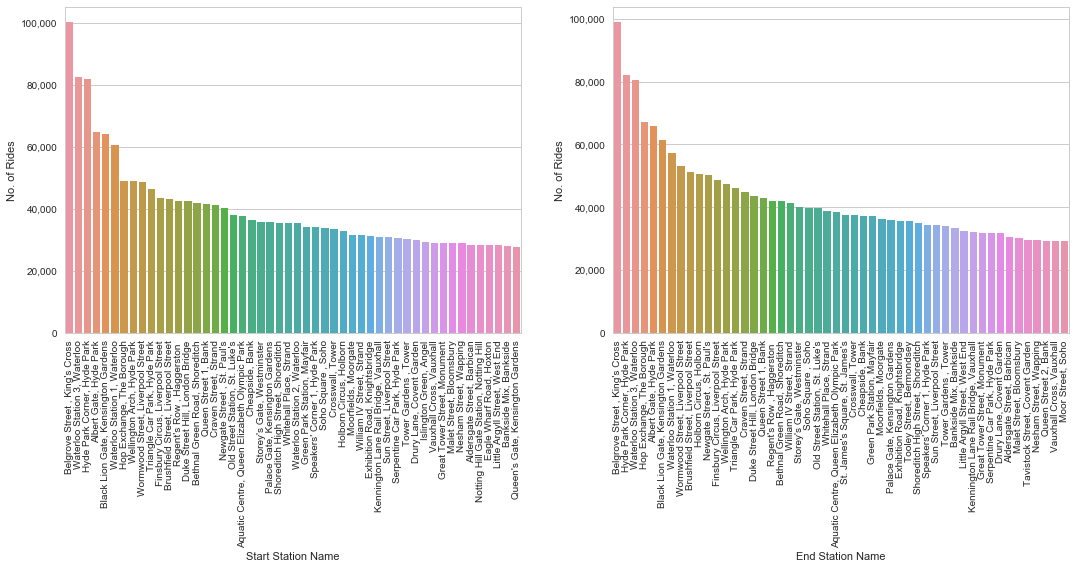

In [17]:
fig, ax = plt.subplots(1,2,figsize=(18, 6))
sns.barplot(x="start_station_name",y="counts",data=start_station_counts.head(50),ax=ax[0])
ax[0].set_ylabel('No. of Rides'),ax[0].set_xlabel('Start Station Name'),ax[0].set_xticklabels(start_station_counts.head(50)['start_station_name'],rotation=90),ax[0].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')));
sns.barplot(x="end_station_name",y="counts",data=end_station_counts.head(50),ax=ax[1])
ax[1].set_ylabel('No. of Rides'),ax[1].set_xlabel('End Station Name'),ax[1].set_xticklabels(end_station_counts.head(50)['end_station_name'],rotation=90),ax[1].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')));

### 5.1 Distributions of Start and End Station Rides

Now that we got a glimpse of the top 50 most popular stations to start and end at, let's look at the distribution of number of rides starting and ending at each station. 

As we see, the start station distribution is shifted slightly to the right compared to the end station distribution. This means that on average we can expect more stations to have more rides starting there than ending there. This could be because riders might be riding from different parts of city into the main business area. This could be problematic from a supply-demand perspective. We will explore that next.

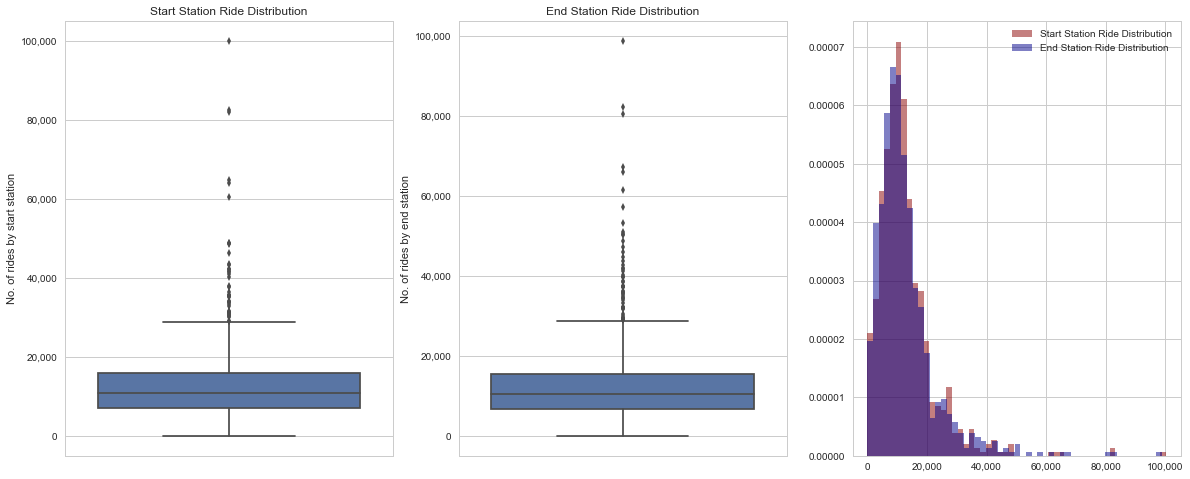

In [23]:
fig, ax = plt.subplots(1,3,figsize=(20,8))
sns.boxplot(start_station_counts['counts'],orient='v',ax=ax[0]),ax[0].set_title('Start Station Ride Distribution'),ax[0].set_ylabel('No. of rides by start station'), ax[0].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
sns.boxplot(end_station_counts['counts'],orient='v',ax=ax[1]), ax[1].set_title('End Station Ride Distribution'),ax[1].set_ylabel('No. of rides by end station'), ax[1].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[2].hist(start_station_counts['counts'], bins ='auto', normed=1, histtype='stepfilled', facecolor='darkred', edgecolor='none', alpha=0.5);
ax[2].hist(end_station_counts['counts'], bins ='auto', normed=1, histtype='stepfilled', facecolor='darkblue', edgecolor='none', alpha=0.5)
ax[2].legend(labels=('Start Station Ride Distribution','End Station Ride Distribution')), ax[2].get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')));

### 5.2 Station Rebalancing

A large part of the costs for a bike sharing system goes in rebalancing. What this means is that when a station has more bikers desiring to hire a bike than dropping it off or vice versa, the system managers need to balance the mismatch. Through our data we can find out which are the stations which are being balanced most by the operators.

As we see below, Borough, Holborn and Waterloo stations have the maximum 'misbalance'. On the second plot we see the violin plot of the misbalance distribution. Most stations don't have much of an issue as the misbalance score is quite small but there is long tail which makes it quite costly. 

A possible strategy could be to use such data to offer dynamic pricing with bikes picked up or dropped off at misbalanced stations being priced higher or lower to offset the cost of balancing.

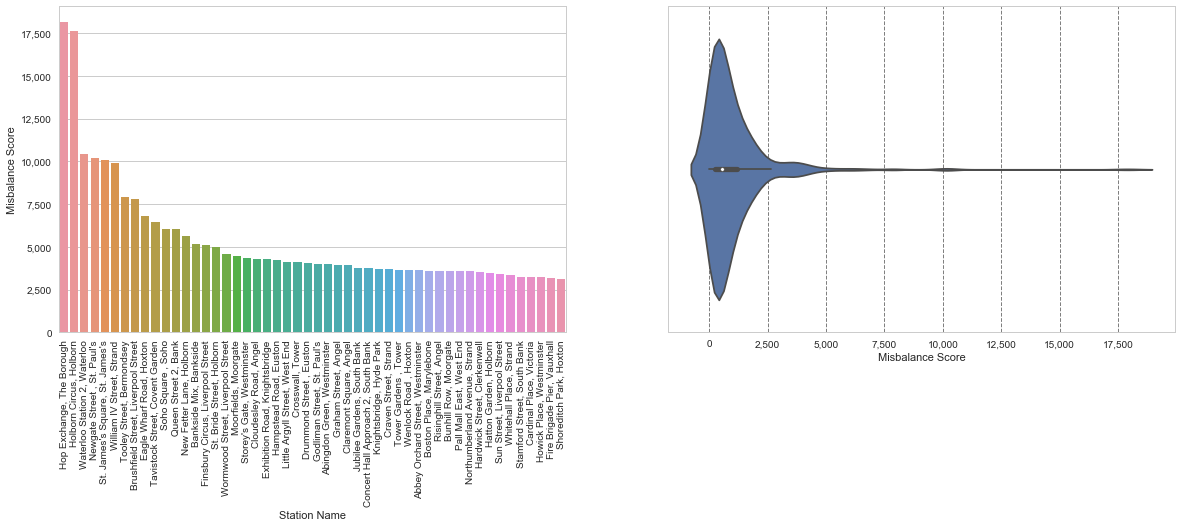

In [28]:
#merge starting station counts with ending station counts so we have number of starts and ends for each station in a row
stations_balancedness = pd.merge(end_station_counts, start_station_counts, how='left', left_on='end_station_name', right_on=['start_station_name'])
stations_balancedness = stations_balancedness[['end_station_name','counts_x','counts_y']]
stations_balancedness.fillna(0, inplace=True)
stations_balancedness['balance'] = abs(stations_balancedness['counts_x']-stations_balancedness['counts_y'])
stations_balancedness=stations_balancedness.sort_values(by=['balance'],ascending=False)
fig, ax = plt.subplots(1,2,figsize=(20, 6))
sns.barplot(x="end_station_name",y="balance",data=stations_balancedness.head(50),ax=ax[0])
ax[0].set_xticklabels(stations_balancedness['end_station_name'].head(50),rotation=90)
ax[0].set_ylabel('Misbalance Score'), ax[0].set_xlabel('Station Name'),ax[0].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
sns.violinplot(x=stations_balancedness['balance'],ax=ax[1])
ax[1].set_xlabel('Misbalance Score'),ax[1].grid(color='grey', which='major', axis='x', linestyle='--'),ax[1].get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')));

### 5.3 Mapping Distance between Stations

Another interesting phenomenon to explore is how the number of rides between any two stations (start and end point) is influenced by distance between them. To do this, we need the geographic coordinates of both the start and end station. TfL provides an XML file with these details and we can convert it to a dataframe before we proceed.

We then group up number of rides between each start and end station pair (for e.g. King's Cross to Liverpool St) and then find the distance between these 2 points in miles.

In [29]:
xml_data = open('Distance Data/stations.xml').read()
root = ET.XML(xml_data) # element tree
all_records = []
#loop through XML tree and extract data from tags
for i, child in enumerate(root):
    record = {}
    for subchild in child:
        record[subchild.tag] = subchild.text
    all_records.append(record)
station_coords = pd.DataFrame(all_records)
station_coords['coords'] = list(zip(station_coords.lat, station_coords.long))
station_coords = station_coords[['id','name','coords']]

In [30]:
#group up rides at a start-end pair level
stations_count = frame.groupby(['start_station_name','end_station_name']).size().reset_index(name='rides')
#merge with station coordinate df
stations_rides_dist = pd.merge(stations_count, station_coords, how='inner', left_on=['start_station_name'], right_on=['name'])
stations_rides_dist = pd.merge(stations_rides_dist, station_coords, how='inner', left_on=['end_station_name'], right_on=['name'])
stations_rides_dist = stations_rides_dist[['start_station_name','end_station_name','rides','coords_x','coords_y']]
#calculate distance between two stations
stations_rides_dist['dist'] = stations_rides_dist.apply(lambda row: geopy.distance.vincenty(row['coords_x'], row['coords_y']).miles, axis=1)
stations_rides_dist.head()

,start_station_name,end_station_name,rides,coords_x,coords_y,dist
0,"Abbey Orchard Street, Westminster","Abbey Orchard Street, Westminster",218,"(51.49812559, -0.132102166)","(51.49812559, -0.132102166)",0.000000
1,"Abingdon Green, Westminster","Abbey Orchard Street, Westminster",81,"(51.497622, -0.125978)","(51.49812559, -0.132102166)",0.266543
2,"Abingdon Villas, Kensington","Abbey Orchard Street, Westminster",2,"(51.4973875, -0.197245586)","(51.49812559, -0.132102166)",2.811431
3,"Abyssinia Close, Clapham Junction","Abbey Orchard Street, Westminster",1,"(51.460333, -0.167029)","(51.49812559, -0.132102166)",3.016510
4,"Ada Street, Hackney Central","Abbey Orchard Street, Westminster",4,"(51.53571683, -0.060291813)","(51.49812559, -0.132102166)",4.043171


### 5.4 Influence of Distance

Now that we have no. of rides between unique start and end points as well as the distance separating them, we can visualise the interaction. The best way to visualise this is a Hexbin plot due to the high volume of points. The number of points at any coordinate are put into a bin and the no. of points within the bin determines the color. 

From the figure we can infer 2 points:
- If we are interested in stations with high volume of traffic between them i.e. more rides between those 2 points, this happens between 0-2 miles. These could represent regular commuters who use a fixed path, solving their last mile problem.
- If we are interested in absolute volume, most rides fall in the 1-4 miles space, with decreasing presence of repeat commutes.

This graph can be useful to help plan future stations roll out by planning within these distance parameters from popular stations.

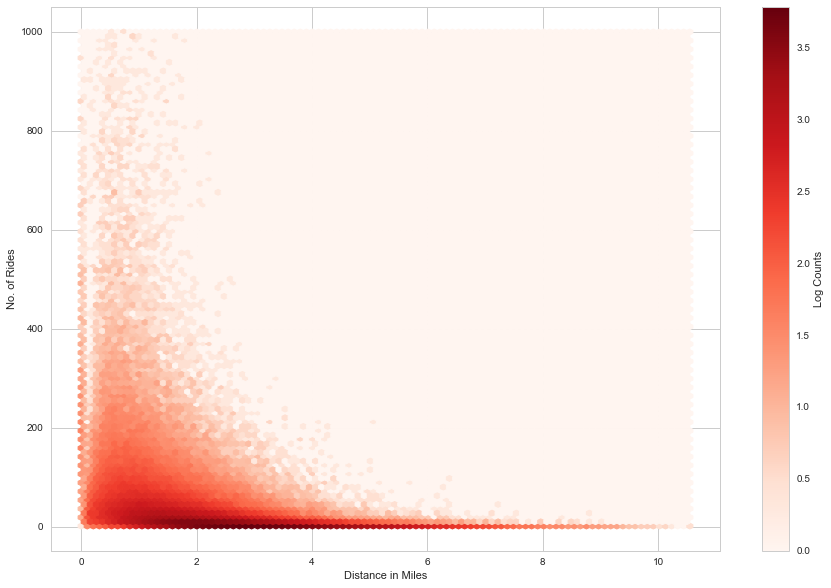

In [31]:
#limit outliers so the visualisation is more meaningful
stations_rides_dist_restricted = stations_rides_dist.loc[stations_rides_dist['rides'] <= 1000]
fig, ax = plt.subplots(figsize=(15, 10))
#use hexbinning to visualise large number of points and use a log scale to show more granular gradient flow
hb = ax.hexbin(stations_rides_dist_restricted['dist'], stations_rides_dist_restricted['rides'],bins='log', cmap='Reds')
ax.set_ylabel("No. of Rides"),ax.set_xlabel('Distance in Miles')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Log Counts');

### 6.0 Network Interactions

Previously, we took a look at how rides between any two stations were influenced by the distance between them. Essentially, these stations form a biking network and thus, it would be logical to next look at how this network works and understand any interesting properties of this network or its nodes. 

In [32]:
import networkx as nx
try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either PyGraphviz or pydot")

### 6.1 Creating the Graph

We start by creating the graph based on our dataframe of rides between stations. Each station becomes a node of the graph and an edge is added if there is a ride between those two stations i.e. someone rode from station A to station B. We exclude edges where there are less than 25 rides between the 2 stations over the year. We use this value as this is the 75th percentile point and we want to remove these edges and focus on more consistent network interactions. 

In [33]:
G = nx.Graph()
#limit number of edges (25 is the 75th percentile of the rides distribution)
stations_count_clean = stations_count.loc[stations_count['rides']>=25]
for index, row in stations_count_clean.iterrows():
    G.add_edge(row['start_station_name'], row['end_station_name'])
print("Graph has %d nodes with %d edges" % (nx.number_of_nodes(G), nx.number_of_edges(G)))

Graph has 800 nodes with 57661 edges


### 6.2 Visualising the Degrees

As a start, we look at the degrees of each node. Degrees represents the number of direct connections a node has to other nodes. As we see, most stations have connections to 100-200 other stations. Stations with the most degrees represent a form of network power as a source or sink i.e. a lot of bikers hire bikes from here or bike into this station. These stations could represent business centers, universities or other key points. 

Planners can use this knowledge to plan bike lanes or alternate forms of last mile transport to serve these junctions.

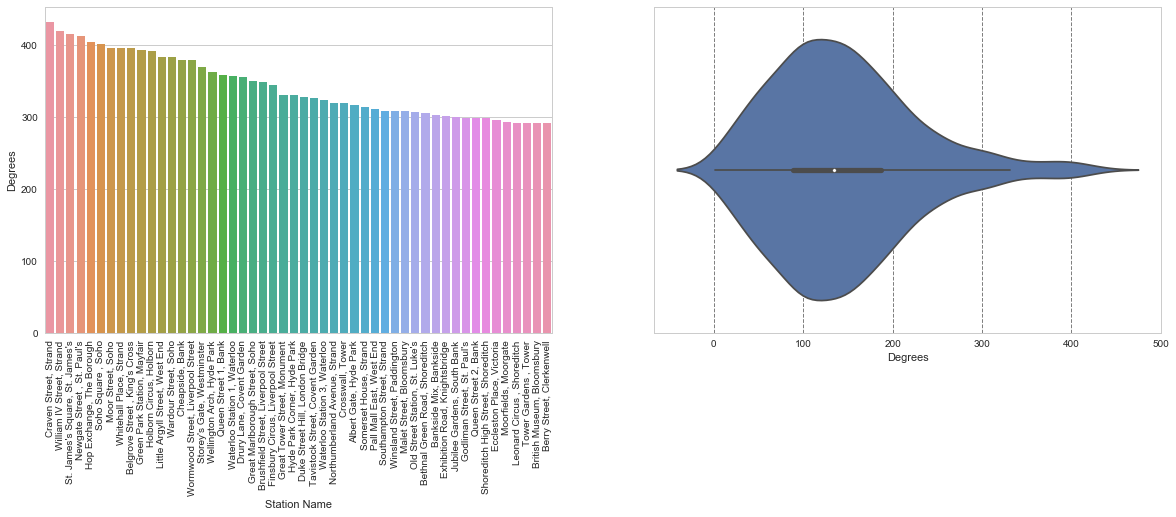

In [34]:
#get the degrees of each node and convert the dictionary to a dataframe
deg_df = pd.DataFrame(list(nx.degree(G).items()),columns=['station','degrees']).sort_values(by='degrees',ascending=0)
fig, ax = plt.subplots(1,2,figsize=(20, 6))
sns.barplot(x="station",y="degrees",data=deg_df.head(50),ax=ax[0])
ax[0].set_xticklabels(deg_df['station'].head(50),rotation=90)
ax[0].set_ylabel('Degrees'), ax[0].set_xlabel('Station Name')
sns.violinplot(x=deg_df['degrees'],ax=ax[1])
ax[1].set_xlabel('Degrees'),ax[1].grid(color='grey', which='major', axis='x', linestyle='--');

### 6.4 Visualising Betweenness-Centrality

An interest concept in network analysis is betweenness centrality. What this represents is a metric to quantify the number of shortest paths between any 2 nodes that go through a particular node of interest. In informational networks this is an important metric to understand network power of a node. 

In the case of bikes stations, a high betweenness-centrality score could mean that this station could be a great bridge between any two stations which might be further away. So we see that St. James' Square has the highest score. What this could mean is that there are quite a few stations connected to St. James' Square which are not connected themselves (no riders riding between these 2 points). 

Thus, this score is another metric which planners could use while looking towards expansion. Expanding outward from these nodes would increase the networks reach into further out suburb areas.

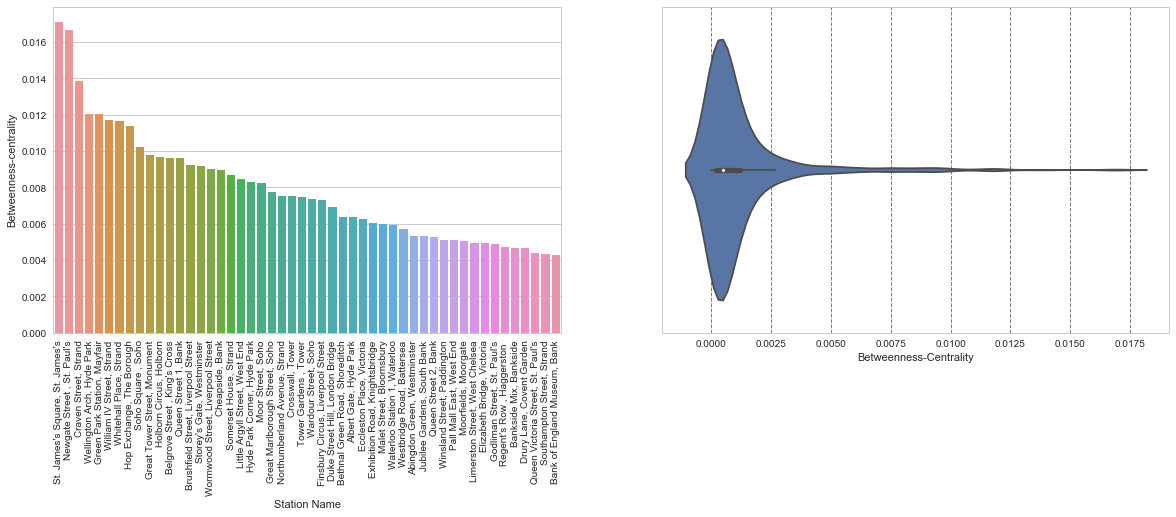

In [35]:
#get betweenness centrality for each node and convert the resulting dictionary to a dataframe
bc_df = pd.DataFrame(list(nx.betweenness_centrality(G).items()),columns=['station','betweenness-centrality']).sort_values(by='betweenness-centrality',ascending=0)
fig, ax = plt.subplots(1,2,figsize=(20, 6))
sns.barplot(x="station",y="betweenness-centrality",data=bc_df.head(50),ax=ax[0])
ax[0].set_xticklabels(bc_df['station'].head(50),rotation=90)
ax[0].set_ylabel('Betweenness-centrality'), ax[0].set_xlabel('Station Name')
sns.violinplot(x=bc_df['betweenness-centrality'],ax=ax[1])
ax[1].set_xlabel('Betweenness-Centrality'),ax[1].grid(color='grey', which='major', axis='x', linestyle='--');

### 6.5 Visualising the Network

Lastly, we will visualise the network of interactions between stations. Since the network is large, we need to reduce its size to be able to visualise it meaningfully. Through trial and error, we limit the graph by limiting the number of edges (by restricting the minimum no. of rides between 2 nodes to be considered an edge) and by limiting the number of nodes by removing nodes with fewer connections to other stations. By doing so, we can focus on the most connected and important stations. We also cap the number of rides between 2 stations at 2000 as the outliers were skewing the distribution which prevents meaningfully visualising the traffic as a color gradient.

In [36]:
G = nx.Graph()
#restrict number of edges
stations_count_restricted = stations_count.loc[stations_count['rides'] >= 200]
#cap the number of rides between 2 stations (for visualising weights in the graph). 2000 is around the 99th percentile.
stations_count_restricted['rides'] = stations_count_restricted['rides'].clip(upper=2000)
for index, row in stations_count_restricted.iterrows():
    G.add_edge(row['start_station_name'], row['end_station_name'],weight=row['rides'])
# remove isolated vertices (if any)    
remove = [node for node,degree in G.degree().items() if degree <=30]
G.remove_nodes_from(remove)
remove = [node for node,degree in G.degree().items() if degree <=2]
G.remove_nodes_from(remove)

### 6.6 Neato!

We use the 'neato' visualisation which tries to find patterns among the nodes based on information from the graph itself. We can see that there are clusters based on geography that emerge with Hyde park being an important node with its own cluster and then a central cluster centered on Waterloo. 

This information is again very useful to planners when looking into network expansion as well as investing in biker friendly infrastructure.

You can replace 'neato' in the code below with 'fdp','dot','circo' etc to try other graph visualisations.

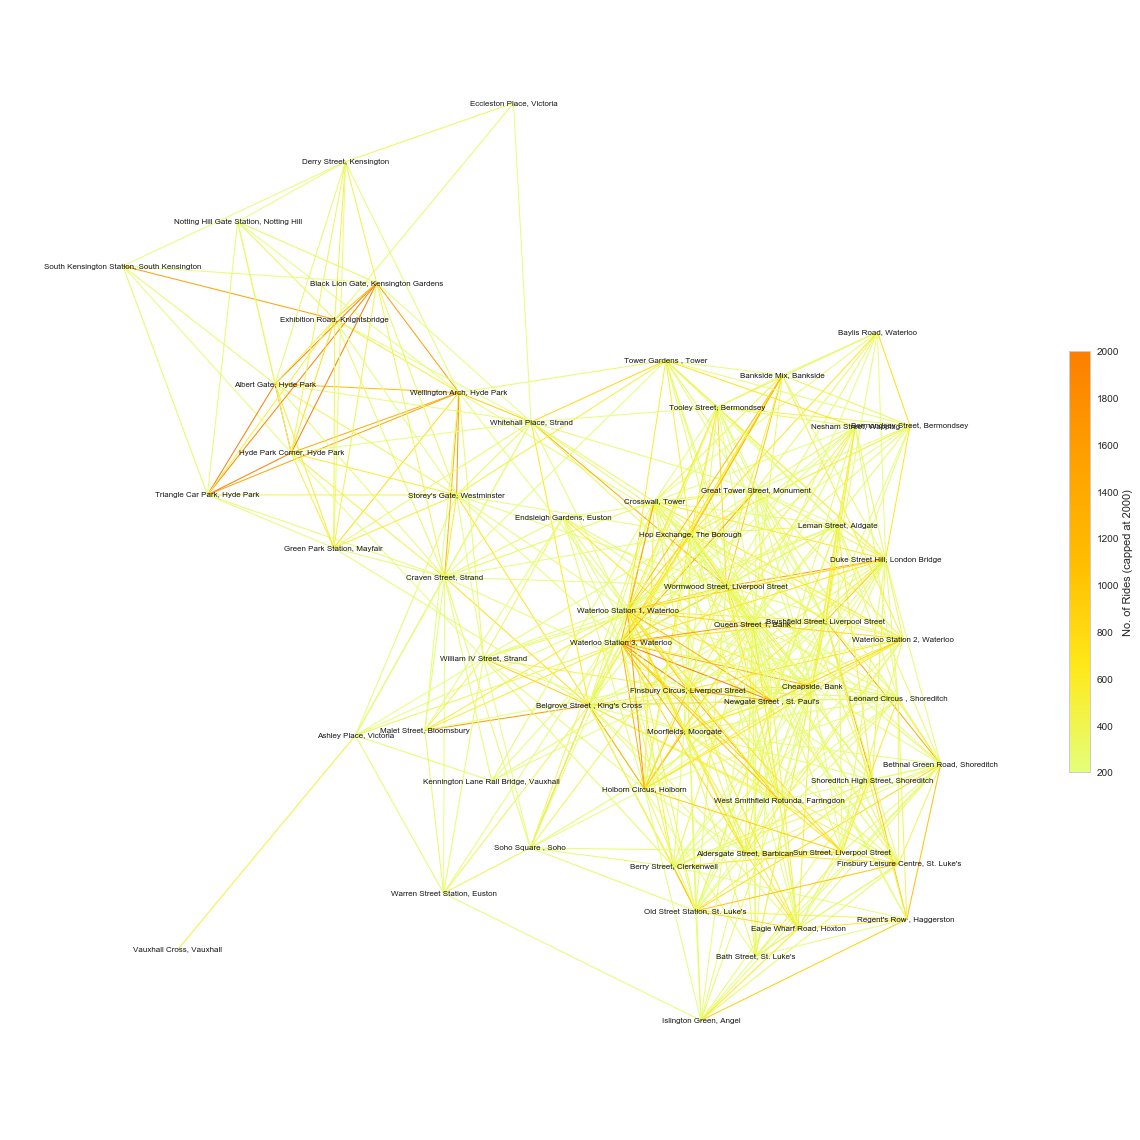

In [37]:
plt.subplots(figsize=(16,16))
#get the weights of the graph -> weights will be usef for the color map of the edges
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
pos = graphviz_layout(G, prog="neato")
nx.draw(G, pos, node_color='g',node_size=0.4, edgelist=edges, edge_color=weights, width=1, edge_cmap=plt.cm.Wistia)
nx.draw_networkx_labels(G,pos=pos,font_size=8)
#draw color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.Wistia)
sm._A = []
sm.set_clim(min(weights), max(weights))
cbar = plt.colorbar(sm,fraction=0.02, pad=0.04)
cbar.set_label('No. of Rides (capped at 2000)')
plt.tight_layout();

### 7.0 Conclusion

To recap, we took a look at a dataset with more than 10 Million bike rides in London over 2016. We explored how riders change their biking decisions based on the time of the day and the day of the year. We then looked at how weather is an important factor that affects a riders decision to ride. Finally, we explored the more intricate dates of the stations themselves by looking at it from a network standpoint. 

There are a lot of interesting takeaways bike system planners can look into using this data and this is just an exploratory start. 

Possible future research could look into:
- Building a prediction model that can predict demand for bikes at any station based on previous demand, weather, seasonality etc. This can help in station rebalancing and maintenance schedules.
- Visualising the bike network using a geospatial map and plotting out hot areas for biking
- Looking into growth metrics by comparing YoY data of the biking system

Big credits to Transport for London and Met Office for their open data. A big thank you to Prof. Kenneth Benoit, Prof. Milan Vojnovic and Christine Yuen from the LSE for equipping me with the tools to embark on this project.

### It will be greatly appreciated if you [**take a minute to give some feedback!**](https://goo.gl/forms/RnHc50Etd3aNVMtS2)